<a href="https://colab.research.google.com/github/Kumkum-1991/kumkum123/blob/main/Copy_of_lipsync_text_extraction_lip_movement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**importing required libraries we required to accomplish this project**

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import pdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured")
except:
    print("GPU not available or not configured")

GPU not available or not configured


In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=6ef3065c-d70c-4ef0-a679-b4e7f7131923
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 137MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

**Building data loading functions**

In [ ]:
import cv2
import tensorflow as tf
from typing import List

def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []

    # Iterate over each frame in the video
    while True:
        ret, frame = cap.read()

        # If there are no more frames, break the loop
        if not ret:
            break

        # Convert frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Crop frame to desired dimensions
        frame = frame[190:236, 80:220]

        # Resize frame to match expected shape
        frame = cv2.resize(frame, (140, 46))

        # Add a channel dimension to the frame
        frame = tf.expand_dims(frame, axis=-1)

        # Convert frame to float32
        frame = tf.cast(frame, tf.float32)

        # Append the processed frame to the list of frames
        frames.append(frame)

    cap.release()

    # Stack the list of frames into a single tensor
    frames = tf.stack(frames)

    # Compute mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(frames)

    # Normalize the frames
    frames = tf.cast((frames - mean), tf.float32) / std

    return frames

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:

def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split(os.path.sep)[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# **2. Create Data Pipeline**

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [ ]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
frames

array([[[[[ 0.17152958],
          [ 0.2926345 ],
          [ 0.2926345 ],
          ...,
          [-0.87804633],
          [-0.87804633],
          [-0.87804633]],

         [[ 0.05042465],
          [ 0.25226617],
          [ 0.21189788],
          ...,
          [-0.87804633],
          [-0.87804633],
          [-0.87804633]],

         [[ 0.2926345 ],
          [ 0.2926345 ],
          [ 0.25226617],
          ...,
          [-0.87804633],
          [-0.91841465],
          [-0.91841465]],

         ...,

         [[-0.11104856],
          [-0.19178517],
          [-0.19178517],
          ...,
          [-1.1202562 ],
          [-1.1202562 ],
          [-1.1202562 ]],

         [[-0.19178517],
          [-0.19178517],
          [-0.19178517],
          ...,
          [-1.1202562 ],
          [-1.1202562 ],
          [-1.1202562 ]],

         [[-0.19178517],
          [-0.19178517],
          [-0.19178517],
          ...,
          [-1.1202562 ],
          [-1.1202562 ],
          

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 0.21766084],
          [ 0.21766084],
          [ 0.21766084],
          ...,
          [-0.8570518 ],
          [-0.8570518 ],
          [-0.8570518 ]],

         [[ 0.21766084],
          [ 0.21766084],
          [ 0.21766084],
          ...,
          [-0.8570518 ],
          [-0.8570518 ],
          [-0.8570518 ]],

         [[ 0.09824833],
          [ 0.09824833],
          [ 0.09824833],
          ...,
          [-0.8570518 ],
          [-0.89685595],
          [-0.89685595]],

         ...,

         [[-0.22018504],
          [-0.22018504],
          [-0.22018504],
          ...,
          [-1.1754851 ],
          [-1.1754851 ],
          [-1.1754851 ]],

         [[-0.2599892 ],
          [-0.2599892 ],
          [-0.2599892 ],
          ...,
          [-1.2550935 ],
          [-1.2550935 ],
          [-1.2550935 ]],

         [[-0.2599892 ],
          [-0.2599892 ],
          [-0.2599892 ],
          ...,
          [-1.2550935 ],
          [-1.2550935 ],
          

In [ ]:
print(val[0][0])

[[[[ 0.21766084]
   [ 0.21766084]
   [ 0.21766084]
   ...
   [-0.8570518 ]
   [-0.8570518 ]
   [-0.8570518 ]]

  [[ 0.21766084]
   [ 0.21766084]
   [ 0.21766084]
   ...
   [-0.8570518 ]
   [-0.8570518 ]
   [-0.8570518 ]]

  [[ 0.09824833]
   [ 0.09824833]
   [ 0.09824833]
   ...
   [-0.8570518 ]
   [-0.89685595]
   [-0.89685595]]

  ...

  [[-0.22018504]
   [-0.22018504]
   [-0.22018504]
   ...
   [-1.1754851 ]
   [-1.1754851 ]
   [-1.1754851 ]]

  [[-0.2599892 ]
   [-0.2599892 ]
   [-0.2599892 ]
   ...
   [-1.2550935 ]
   [-1.2550935 ]
   [-1.2550935 ]]

  [[-0.2599892 ]
   [-0.2599892 ]
   [-0.2599892 ]
   ...
   [-1.2550935 ]
   [-1.2550935 ]
   [-1.2550935 ]]]


 [[[ 0.1380525 ]
   [ 0.1380525 ]
   [ 0.17785667]
   ...
   [-0.9764643 ]
   [-0.9764643 ]
   [-0.9764643 ]]

  [[ 0.1380525 ]
   [ 0.1380525 ]
   [ 0.17785667]
   ...
   [-0.9764643 ]
   [-0.9764643 ]
   [-0.9764643 ]]

  [[ 0.09824833]
   [ 0.09824833]
   [ 0.09824833]
   ...
   [-0.89685595]
   [-0.89685595]
   [-0.8968

In [ ]:
print(val[0][0].shape)

(75, 46, 140, 1)


In [ ]:
import numpy as np
import imageio


print("Data Range:", np.min(val[0][0]), "-", np.max(val[0][0]))


max_val = np.max(val[0][0])
min_val = np.min(val[0][0])
frames_normalized = (val[0][0] - min_val) / (max_val - min_val) * 255

frames_uint8 = frames_normalized.astype(np.uint8)

frames_rgb = np.repeat(frames_uint8, 3, axis=-1)

imageio.mimsave('./animation.gif', frames_rgb, fps=10)

Data Range: -4.678252 - 2.4068902


In [ ]:
from PIL import Image


# Load the animated GIF
gif_path = './animation.gif'
gif = imageio.mimread(gif_path)

# Convert each frame to grayscale
grayscale_frames = []
for frame in gif:
    # Convert the frame to a PIL Image object
    pil_frame = Image.fromarray(frame)

    # Convert the frame to grayscale
    grayscale_frame = pil_frame.convert('L')

    # Convert the grayscale frame back to numpy array
    grayscale_array = np.array(grayscale_frame)

    # Append the grayscale frame to the list of grayscale frames
    grayscale_frames.append(grayscale_array)

# Save the grayscale frames as a new animated GIF
output_path = './animation_grayscale.gif'
imageio.mimsave(output_path, grayscale_frames, fps=10)

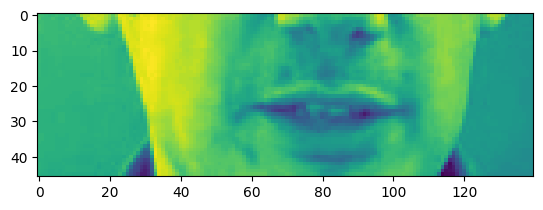

In [ ]:
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green by p five soon'>

##                          **Design the Deep Neural Network** 😃







In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 33s 33s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bjjjjjjjjjppppppppyyyy'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bjjjjjjjjjppppppppyyyy'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# **                         . Setup Training Options and Train!!**

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
 29/450 [>.............................] - ETA: 7:06:33 - loss: 129.1694

# .                       ** Make a Prediction**

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create a v2.11+ optimizer
optimizer = Adam()

# Load the weights into the model using the v2.11+ optimizer
model.load_weights('models/checkpoint', optimizer=optimizer)

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]